In [1]:
import pandas as pd
import numpy as np
from transformers import pipeline
import torch

import warnings
warnings.filterwarnings('ignore')

c:\Users\Pc\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [22]:
from datasets import load_dataset

samsum = load_dataset("Samsung/samsum")

In [32]:
dialogue_len = [len(x['dialogue'].split()) for x in samsum['train']]
summary_len = [len(x['summary'].split()) for x in samsum['train']]

array([[<Axes: title={'center': 'Dialogue Length'}>,
        <Axes: title={'center': 'Summary Length'}>]], dtype=object)

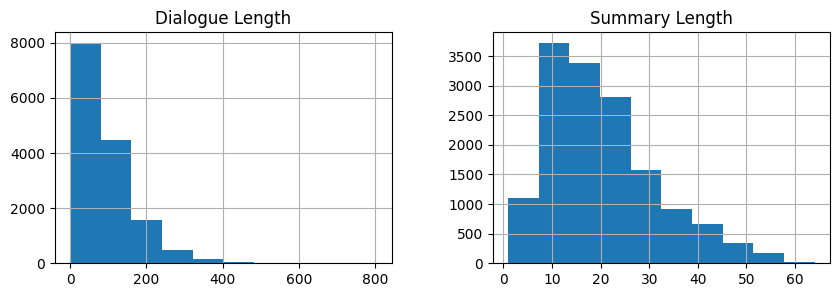

In [33]:
data = pd.DataFrame([dialogue_len, summary_len]).T
data.columns = ['Dialogue Length', 'Summary Length']

data.hist(figsize=(10,3))           # max_length = 200 olarak alıyoruz daha hızlı yapalım diye

In [34]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_ckpt = 't5-small'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

- AutoModelForSeq2SeqLM: Seq2Seq (Encoder-Decoder) yapılarında kullanılır. Bu, T5 veya BART gibi modeller için uygundur (özellikle özetleme, çeviri gibi görevler için).

In [35]:
tokenizer(samsum['train'][0]['dialogue'], text_target=samsum['train'][0]['summary'], return_tensors='pt')

{'input_ids': tensor([[21542,    10,    27, 13635,  5081,     5,   531,    25,   241,   128,
            58, 16637,    10, 10625,    55, 21542,    10,    27,    31,   195,
           830,    25,  5721,     3,    10,    18,    61,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1]]), 'labels': tensor([[21542, 13635,  5081,    11,    56,   830, 16637,   128,  5721,     5,
             1]])}

In [36]:
def tokenize(batch):
    encoding = tokenizer(batch['dialogue'], text_target=batch['summary'], max_length=200, truncation=True, padding=True, return_tensors='pt')

    return encoding

In [37]:
samsum_pt = samsum.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [38]:
samsum_pt

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [42]:
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

args = TrainingArguments(
    output_dir= r"C:\Temp\bert_base_train_dir",
    num_train_epochs=2,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy='epoch',
    save_strategy='epoch',
    weight_decay=0.01,
    learning_rate=2e-5,
    gradient_accumulation_steps=500
)

trainer = Trainer(model=model,
                  args=args,
                  tokenizer=tokenizer,  #prediction da lazım train ederken değil. onu zaten yapıyoruz önceden
                  data_collator=data_collator,
                  train_dataset=samsum_pt['train'],
                  eval_dataset=samsum_pt['validation']
                  )

trainer.train()

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 14.653148651123047, 'eval_runtime': 56.8446, 'eval_samples_per_second': 14.39, 'eval_steps_per_second': 3.606, 'epoch': 0.95}


  0%|          | 0/205 [00:00<?, ?it/s]

{'eval_loss': 13.786165237426758, 'eval_runtime': 53.7971, 'eval_samples_per_second': 15.205, 'eval_steps_per_second': 3.811, 'epoch': 1.9}
{'train_runtime': 7744.8911, 'train_samples_per_second': 3.804, 'train_steps_per_second': 0.002, 'train_loss': 14.073525565011161, 'epoch': 1.9}


TrainOutput(global_step=14, training_loss=14.073525565011161, metrics={'train_runtime': 7744.8911, 'train_samples_per_second': 3.804, 'train_steps_per_second': 0.002, 'total_flos': 1480300953600000.0, 'train_loss': 14.073525565011161, 'epoch': 1.9006244909041543})

##### DataCollatorForSeq2Seq'un Yaptığı İş:

1. Batch Padding: DataCollatorForSeq2Seq tüm batch içindeki en uzun örneğe göre dinamik padding yapar. Senin tokenization kodunda sabit bir max_length=200 verilmiş. Fakat DataCollatorForSeq2Seq her batch’teki en uzun diziyi alır ve ona göre padding yapar. Bu da fazladan padding yapılmamasını sağlar, böylece daha verimli bir eğitim süreci olur.

2. Label Padding: Seq2seq modellerinde sadece girişler değil, çıkışlar (yani özetler) de pad edilmelidir. DataCollatorForSeq2Seq bunu otomatik olarak yapar ve maskeler ekler. Senin kodunda bu işlem manuel olarak yapılmamış, yalnızca text_target kısmı belirlenmiş. DataCollator hem giriş hem de çıkışları doğru şekilde pad eder ve maskeler.

3. Masking: Padding yapılan token'lar için masklar oluşturur. Bu masklar, modelin sadece gerçek token'lar üzerinden öğrenmesini sağlar ve pad edilmiş token'ları dikkate almaz.

##### TrainingArguments, model eğitimi sırasında kullanılan birçok önemli parametreyi içerir, örneğin:

1. Çıkış Dizini (output_dir): Eğitim sonucunda kaydedilecek modelin, checkpoint'lerin (ara kayıtların), log dosyalarının ve diğer sonuçların nereye kaydedileceğini belirtir.

2. Eğitim Süresi (num_train_epochs): Modeli kaç epoch boyunca eğiteceğini belirler. Bir epoch, tüm eğitim verisinin modelden bir kez geçmesi anlamına gelir.

3. Batch Boyutu (per_device_train_batch_size, per_device_eval_batch_size): Modeli eğitirken ve değerlendirirken kullanılacak batch boyutunu belirler. Her cihaz (örneğin GPU) başına kaç veri örneğinin işleneceğini ayarlar.

4. Değerlendirme Stratejisi (eval_strategy): Değerlendirme işleminin ne zaman yapılacağını belirler. Bu değer genellikle "steps", "epoch" veya "no" olabilir.

- "steps": Belirtilen adımlardan sonra değerlendirme yapılır.
- "epoch": Her epoch sonunda değerlendirme yapılır.
- "no": Değerlendirme yapılmaz.
5. Model Kaydetme Stratejisi (save_strategy): Modelin ne zaman kaydedileceğini belirler. "steps" veya "epoch" olabilir.

- "epoch": Her epoch sonunda model kaydedilir.
- "steps": Belirli adımlar sonunda model kaydedilir.

6. Learning Rate (learning_rate): Modelin öğrenme hızını ayarlayan parametre. Bu, modelin ağırlıklarının ne kadar hızla güncelleneceğini belirler.

7. Weight Decay: Aşırı öğrenmeyi önlemek için ağırlıkların azalmasını sağlar. Bu, düzenlileştirici bir parametredir ve modelin daha genel bir şekilde öğrenmesine yardımcı olur.

8. Gradient Accumulation (gradient_accumulation_steps): Bu, toplam batch boyutunu artırmak için gradyanların belirli adımlarda toplanmasını sağlar. Yani, daha küçük batch boyutları kullanarak bellek tasarrufu yapabilir ve aynı zamanda daha büyük bir sanal batch boyutu elde edebilirsin.

Diğer Parametreler: Eğitim sırasında GPU/CPU kullanımı, loglama aralıkları, learning rate scheduler gibi diğer teknik ayarları da belirleyebilirsin.

In [45]:
trainer.save_model(r"C:\Temp\t5_samsum_summarization")

In [47]:
from transformers import pipeline

pipe = pipeline('summarization', model= r"C:\Temp\t5_samsum_summarization")

In [49]:
custom_dialogue= "Take a look at your daily life. Whether at your workplace or sitting at your computer at home, you will see that you are repeating certain tasks in a monotonous way. For instance, you might be working in a job that requires you to deal with written documents constantly. Perhaps you open dozens of documents every day and search for certain information within them, correcting, updating, or deleting this information. Consider how time-consuming and tedious these tasks are. If you knew a programming language, all these tasks could be handled by that programming language instead of you."
output = pipe(custom_dialogue)
output

Your max_length is set to 200, but your input_length is only 124. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=62)


[{'summary_text': 'if you knew a programming language, all these tasks could be handled by that programming language instead of you . take a look at your daily life and see that you are repeating certain tasks in a monotonous way .'}]